## Assignment 3: RNN/LSTM for stock price prediction

In [859]:
## imports
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.utils.data import DataLoader,TensorDataset
from torch.optim import Adam,AdamW,RMSprop,SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error

### Data setup

run the following code in terminal to downlaod dataset


curl https://www.kaggle.com/api/v1/datasets/download/rahulsah06/gooogle-stock-price -o data.zip

In [915]:
os.makedirs("dataset",exist_ok=True)
with zipfile.ZipFile("data.zip","r") as f:
    f.extractall("dataset")

In [916]:
train=pd.read_csv("dataset/Google_Stock_Price_Train.csv")
test=pd.read_csv("dataset/Google_Stock_Price_Test.csv")

### EDA

In [917]:
train.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [918]:
train.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

In [919]:
## data cleaning
## found one of the close cloumns had a "," leading it to read as object type thus cleaning
train["Date"]=train["Date"].astype("datetime64[s]")
train["Close"]=train["Close"].apply(lambda row: row.replace(",","")).astype(float)
train["Volume"]= train["Volume"].apply(lambda row: row.replace(",","")).astype(float).astype(int)

In [920]:
train.describe(include='all')

,Date,Open,High,Low,Close,Volume
count,1258,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,2014-07-03 20:00:45,533.709833,537.880223,529.007409,712.669666,3.158107e+06
min,2012-01-03 00:00:00,279.120000,281.210000,277.220000,491.200000,7.900000e+03
25%,2013-04-05 18:00:00,404.115000,406.765000,401.765000,576.740000,1.621700e+06
50%,2014-07-05 00:00:00,537.470000,540.750000,532.990000,695.675000,2.566150e+06
75%,2015-10-01 18:00:00,654.922500,662.587500,644.800000,782.105000,4.122500e+06
max,2016-12-30 00:00:00,816.680000,816.680000,805.140000,1216.830000,2.497790e+07
std,NaN,151.904442,153.008811,150.552807,164.752591,2.273726e+06


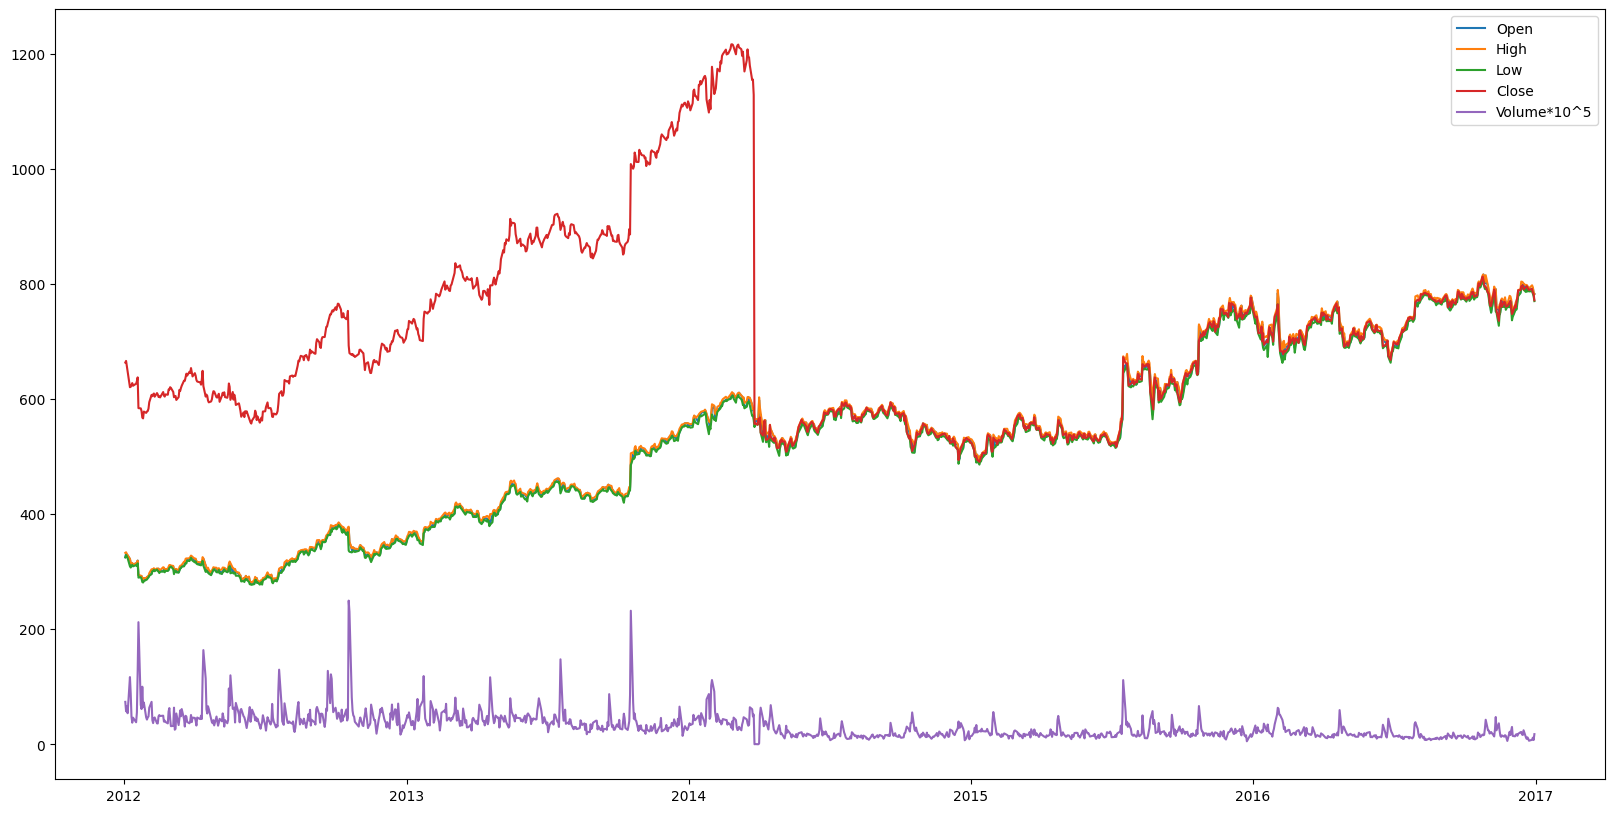

In [921]:
plt.figure(figsize=(20,10))
plt.plot(train["Date"],train["Open"],label="Open")
plt.plot(train["Date"],train["High"],label="High")
plt.plot(train["Date"],train["Low"],label="Low")
plt.plot(train["Date"],train["Close"],label="Close")
plt.plot(train["Date"],train["Volume"]/10**5,label="Volume*10^5")
plt.legend()
plt.show()

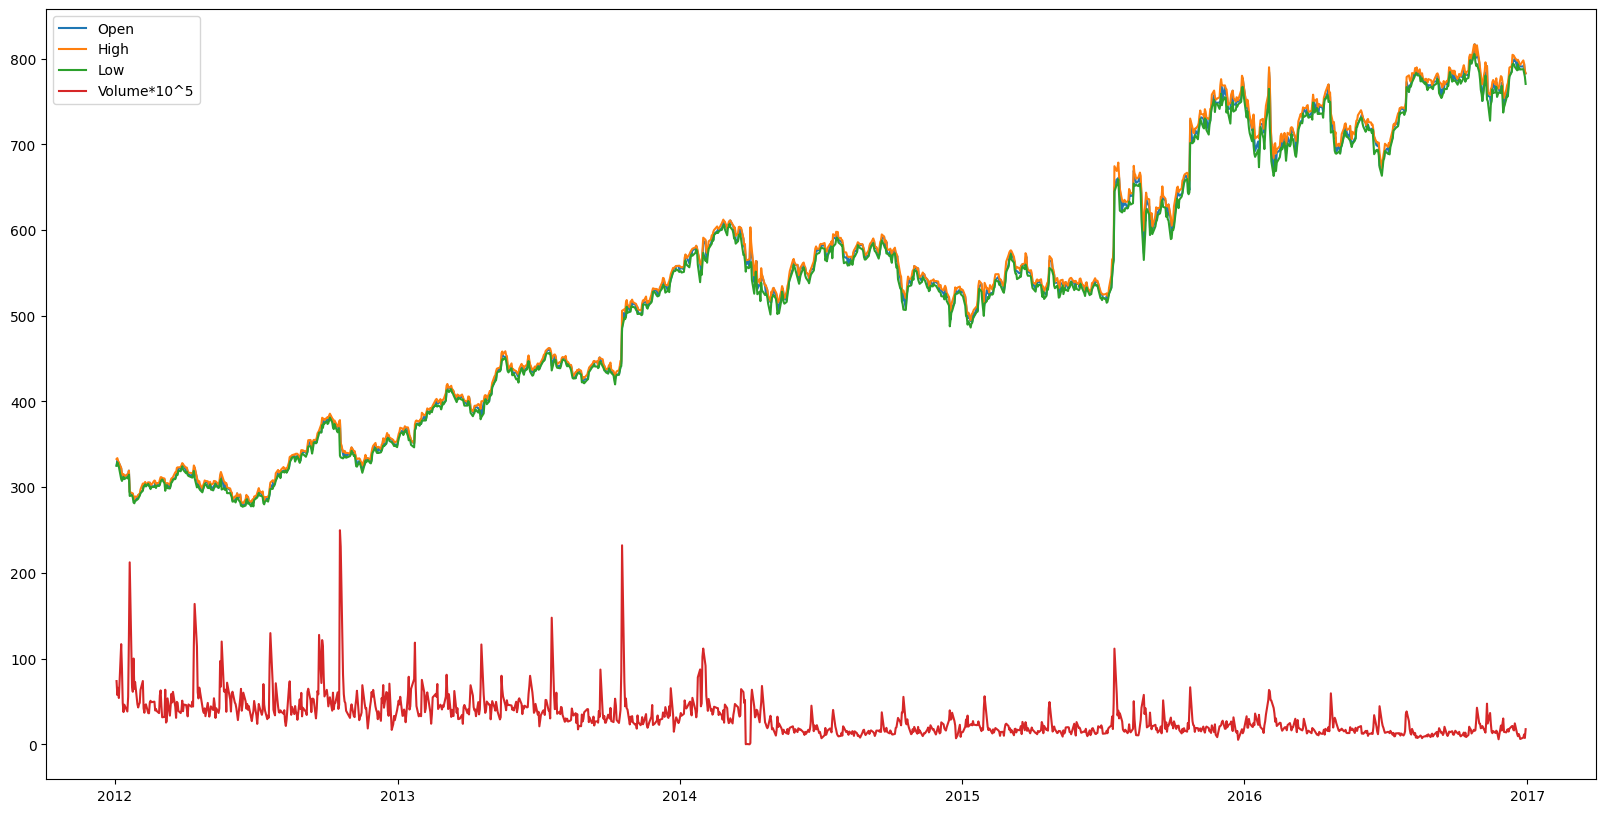

In [922]:
## since the Close is higher than High, Close is corrupted and not reliable, thus we wont be using Close
## i.e we wont be dealing with Close column we will only be using Open, low and high
#train.drop(labels="Close",inplace=True,axis=1)
plt.figure(figsize=(20,10))
plt.plot(train["Date"],train["Open"],label="Open")
plt.plot(train["Date"],train["High"],label="High")
plt.plot(train["Date"],train["Low"],label="Low")
plt.plot(train["Date"],train["Volume"]/10**5,label="Volume*10^5")
plt.legend()
plt.show()

In [923]:
test.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [924]:
test.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object

In [ ]:
## removing close from here as well
#test.drop("Close",axis=1,inplace=True)
test["Volume"]= test["Volume"].apply(lambda row: row.replace(",","")).astype(float).astype(int)
test["Date"]=test["Date"].astype("datetime64[s]")

test.describe(include='all')


,Date,Open,High,Low,Close,Volume
count,20,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,2017-01-16 15:36:00,807.526000,811.926500,801.949500,807.904500,1.659895e+06
min,2017-01-03 00:00:00,778.810000,789.630000,775.800000,786.140000,9.193000e+05
25%,2017-01-09 18:00:00,802.965000,806.735000,797.427500,802.282500,1.248500e+06
50%,2017-01-17 12:00:00,806.995000,808.640000,801.530000,806.110000,1.418050e+06
75%,2017-01-24 06:00:00,809.560000,817.097500,804.477500,810.760000,1.743400e+06
max,2017-01-31 00:00:00,837.810000,841.950000,827.010000,835.670000,3.246600e+06
std,NaN,15.125428,14.381198,13.278607,13.210088,6.774747e+05


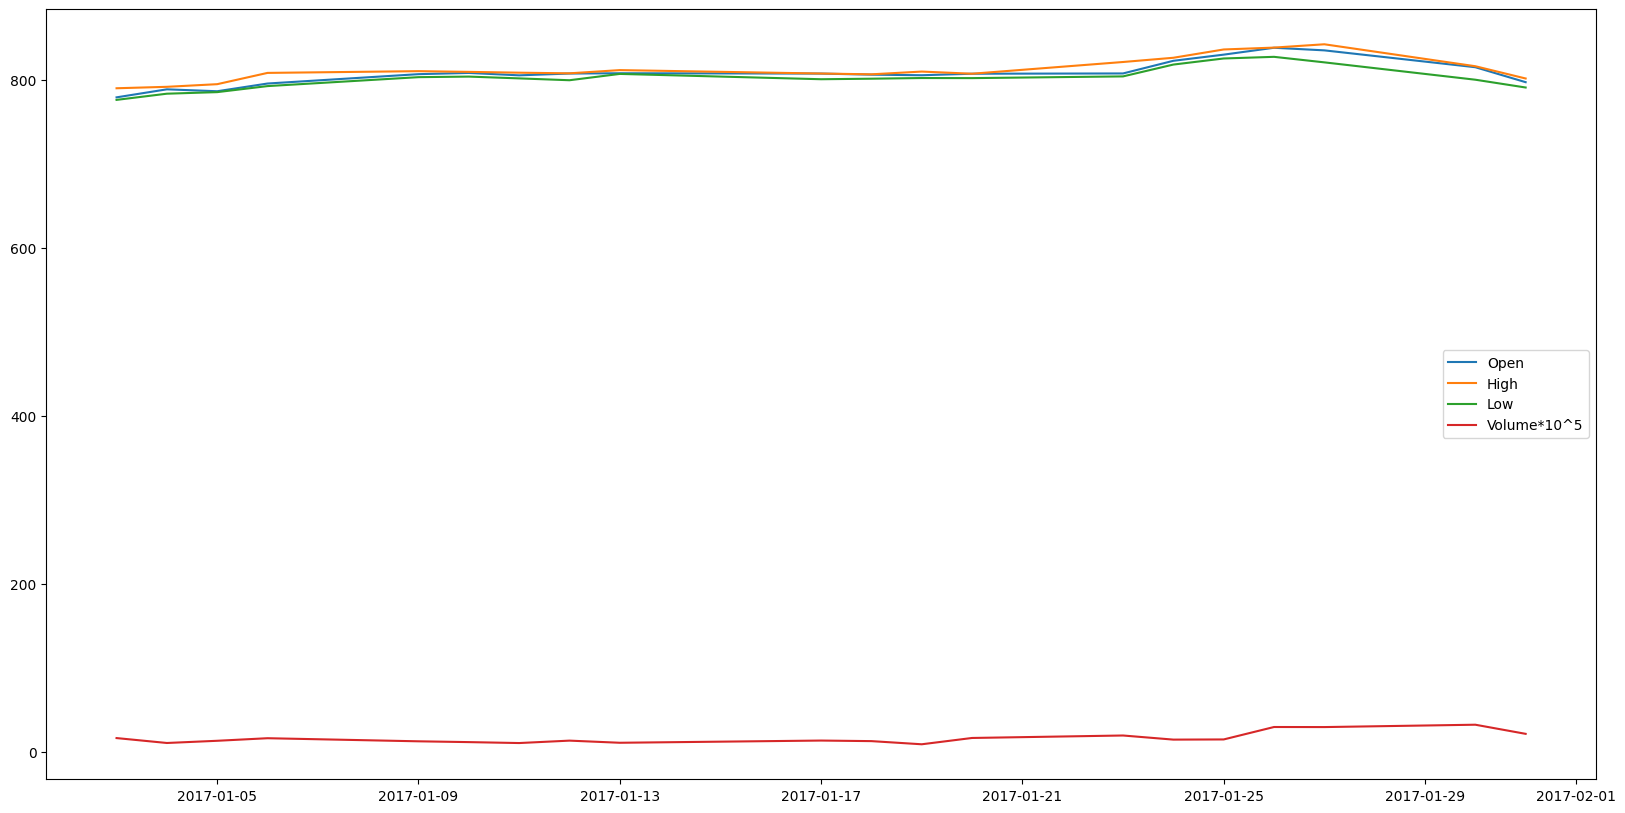

In [926]:
plt.figure(figsize=(20,10))
plt.plot(test["Date"],test["Open"],label="Open")
plt.plot(test["Date"],test["High"],label="High")
plt.plot(test["Date"],test["Low"],label="Low")
plt.plot(test["Date"],test["Volume"]/10**5,label="Volume*10^5")
plt.legend()
plt.show()

In [914]:
## checking if the data is continuous that is if the train's last date is continous with test set
train.tail()["Date"],test.head()["Date"]

(1253   2016-12-23
 1254   2016-12-27
 1255   2016-12-28
 1256   2016-12-29
 1257   2016-12-30
 Name: Date, dtype: datetime64[s],
 0   2017-01-03
 1   2017-01-04
 2   2017-01-05
 3   2017-01-06
 4   2017-01-09
 Name: Date, dtype: datetime64[s])

In [887]:
def get_data(data,past_time_steps=20):
    if(past_time_steps>=1):
        X,y=[],[]
        for i in range(len(data)-past_time_steps):
            X.append(data[i:i+past_time_steps].tolist())
            y.append(data[i+1:i+1+past_time_steps].tolist())
        return torch.tensor(X).unsqueeze(2),torch.tensor(y).unsqueeze(2)
    else:
        print("Not a valid past time steps, should be greater than 0")
        return 

In [888]:
## splitting data
train_split_ratio=0.8
## predicting Open prices for univariate
train_data=train[:int(len(train["Open"])*train_split_ratio)].drop("Date",axis=1).reset_index(drop=True)
valid_data=train[int(len(train["Open"])*train_split_ratio):].drop("Date",axis=1).reset_index(drop=True)
test_data=test.drop("Date",axis=1)
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(1006, 5)
(252, 5)
(20, 5)


In [889]:
scaler=MinMaxScaler(feature_range=(0,1))
train_data=pd.DataFrame(scaler.fit_transform(train_data),columns=train_data.columns)
valid_data=pd.DataFrame(scaler.transform(valid_data),columns=valid_data.columns)
test_data=pd.DataFrame(scaler.transform(test_data),columns=test_data.columns)

### Univariate RNN

In [ ]:
class RNN(nn.Module):

    def __init__(self,input_features,hidden_size,output_size,layers=1):
        super().__init__()
        self._input_features=input_features
        self._hidden_size=hidden_size
        self._output_size=output_size
        self._layers=layers
        self.lstm=nn.RNN(input_size=self._input_features,hidden_size=self._hidden_size,num_layers=self._layers,batch_first=True)
        self.linear=nn.Linear(self._hidden_size,self._output_size)
    
    def forward(self,x):

        x,_=self.lstm(x)
        x=self.linear(x[:,-1,:])
        return x.unsqueeze(-1)

In [891]:
def train_model(model,optim,loss_fn,epochs,train_data,xval,yval):
    model.to("cuda")
    train_rmse_list=[]
    val_rmse_list=[]
    for epoch in range(epochs):
        model.train()
        for X,y in train_data:
            X=X.to("cuda",non_blocking=True)
            y=y.to("cuda",non_blocking=True)
            y_pred=model(X)
            # print(y_pred.shape,y.shape)
            loss=loss_fn(y_pred,y)
            optim.zero_grad()
            loss.backward()
            optim.step()
        if((epoch+1)%10==0):
            model.eval()
            xval=xval.to("cuda",non_blocking=True)
            yval=yval.to("cuda",non_blocking=True)
            with torch.no_grad():
                y_pred=model(xval)
                train_rmse=np.sqrt(loss.item())
                train_rmse_list.append(train_rmse)
                val_loss=loss_fn(y_pred,yval)
                val_rmse=np.sqrt(val_loss.item())
                val_rmse_list.append(val_rmse)
                print(epoch+1,train_rmse,val_rmse)


In [892]:
time_steps=10


X_train,y_train=get_data(train_data["Open"],time_steps)
print("Shapes of train datasets",X_train.shape,y_train.shape)

X_val,y_val=get_data(valid_data["Open"],time_steps)
print("Shapes of valid datasets",X_val.shape,y_val.shape)

train_dataloader=DataLoader(TensorDataset(X_train,y_train),batch_size=8)

rnn_model=RNN(input_features=1,hidden_size=50,output_size=time_steps)
optimizer=Adam(rnn_model.parameters(),lr=0.0001)
loss=nn.MSELoss()

train_model(rnn_model,optimizer,loss,500,train_dataloader,X_val,y_val)


Shapes of train datasets torch.Size([996, 10, 1]) torch.Size([996, 10, 1])
Shapes of valid datasets torch.Size([242, 10, 1]) torch.Size([242, 10, 1])
10 0.12476369008311801 0.11529929142927167
20 0.07346582285052689 0.0677905634093696
30 0.04682761022051236 0.046059953293087194
40 0.03283116315094553 0.03672288734380365
50 0.024635149546729896 0.03286635663639657
60 0.020198962145383262 0.03179780623351701
70 0.018680741938577695 0.031715351771845576
80 0.01846058883137955 0.0317915121595034
90 0.018644566936926312 0.03183505819136088
100 0.018941975206226872 0.031821901863686754
110 0.019263702234510943 0.03174176380417842
120 0.01956439409759283 0.03157136748877418
130 0.019807373192539814 0.03127385696582
140 0.019953752677306417 0.030812420387556938
150 0.019962442369572325 0.030156205634655212
160 0.019800804873744204 0.029268671407699454
170 0.019513583388933078 0.028099700149839733
180 0.019143915228116253 0.026579569974870668
190 0.018586973754459467 0.024900876965053213
200 0.

valid rmse: 11.029202204275602


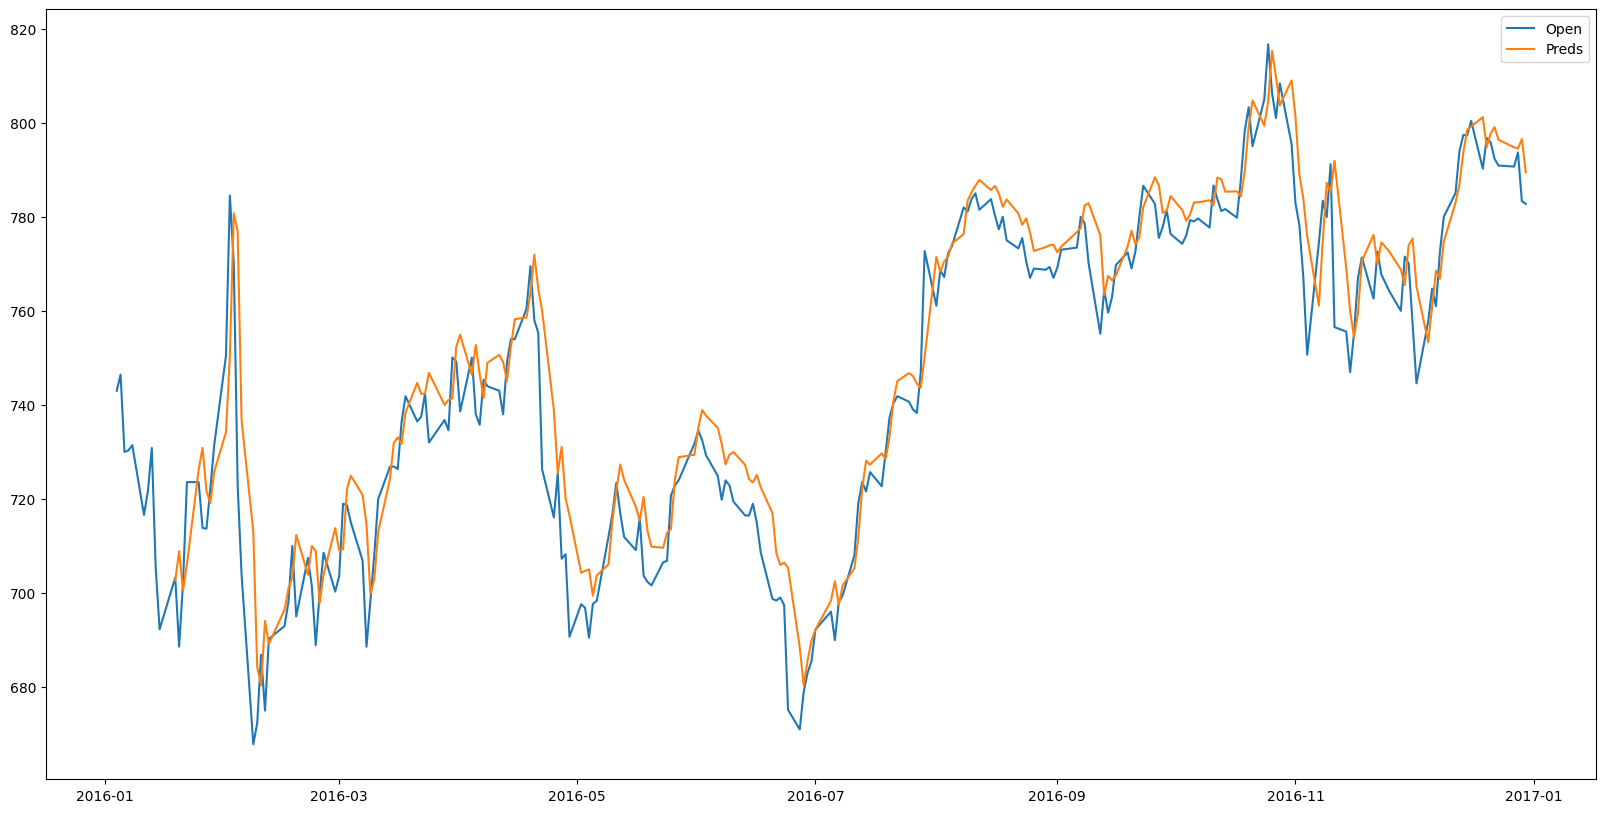

In [893]:
## testing the predictions
with torch.no_grad():
    X_val=X_val.to("cuda",non_blocking=True)
    rnn_model=rnn_model.cuda()
    y_val_preds=[(pred.item()) for pred in rnn_model(X_val)[:,-1,:].squeeze()]
    y_val_preds_df=valid_data.copy()
    y_val_preds_df["Open"]=pd.Series(y_val_preds)
    y_val_preds=pd.DataFrame(scaler.inverse_transform(y_val_preds_df),columns=y_val_preds_df.columns)
    print("valid rmse:",root_mean_squared_error(y_val_preds["Open"].dropna(),train["Open"][time_steps-len(y_val_preds):]))
    plt.figure(figsize=(20,10))
    plt.plot(train["Date"][-len(y_val_preds):],train["Open"][-len(y_val_preds):],label="Open")
    plt.plot(train["Date"][time_steps-len(y_val_preds):],y_val_preds["Open"].dropna(),label="Preds")
    plt.legend()
    plt.show()

### Univariate LSTM

In [875]:
class LSTM(nn.Module):

    def __init__(self,input_features,hidden_size,output_size,layers=1):
        super().__init__()
        self._input_features=input_features
        self._hidden_size=hidden_size
        self._output_size=output_size
        self._layers=layers
        self.lstm=nn.LSTM(input_size=self._input_features,hidden_size=self._hidden_size,num_layers=self._layers,batch_first=True)
        self.linear=nn.Linear(self._hidden_size,self._output_size)
    
    def forward(self,x):

        x,_=self.lstm(x)
        # print(x.shape)
        # print(x[:,-1,:].shape)
        x=self.linear(x[:,-1,:])
        # print(x.shape)
        # print( x.unsqueeze(-1).shape)
        return x.unsqueeze(-1)


In [876]:
def train_model(model,optim,loss_fn,epochs,train_data,xval,yval):
    model.to("cuda")
    train_rmse_list=[]
    val_rmse_list=[]
    for epoch in range(epochs):
        model.train()
        for X,y in train_data:
            X=X.to("cuda",non_blocking=True)
            y=y.to("cuda",non_blocking=True)
            y_pred=model(X)
            # print(y_pred.shape,y.shape)
            loss=loss_fn(y_pred,y)
            optim.zero_grad()
            loss.backward()
            optim.step()
        if((epoch+1)%10==0):
            model.eval()
            xval=xval.to("cuda",non_blocking=True)
            yval=yval.to("cuda",non_blocking=True)
            with torch.no_grad():
                y_pred=model(xval)
                train_rmse=np.sqrt(loss.item())
                train_rmse_list.append(train_rmse)
                val_loss=loss_fn(y_pred,yval)
                val_rmse=np.sqrt(val_loss.item())
                val_rmse_list.append(val_rmse)
                print(epoch+1,train_rmse,val_rmse)


In [877]:
time_steps=10


X_train,y_train=get_data(train_data["Open"],time_steps)
print("Shapes of train datasets",X_train.shape,y_train.shape)

X_val,y_val=get_data(valid_data["Open"],time_steps)
print("Shapes of valid datasets",X_val.shape,y_val.shape)

train_dataloader=DataLoader(TensorDataset(X_train,y_train),batch_size=8)

model=LSTM(input_features=1,hidden_size=50,output_size=time_steps)
optimizer=Adam(model.parameters(),lr=0.0001)
loss=nn.MSELoss()

train_model(model,optimizer,loss,500,train_dataloader,X_val,y_val)


Shapes of train datasets torch.Size([996, 10, 1]) torch.Size([996, 10, 1])
Shapes of valid datasets torch.Size([242, 10, 1]) torch.Size([242, 10, 1])
10 0.08892537926060007 0.08119220730035615
20 0.03966390655619163 0.041401668454808575
30 0.034922749891885436 0.03762925046693839
40 0.03116350291724694 0.03500703098677916
50 0.027617941372967275 0.03248923174598398
60 0.023923371397998695 0.030357941811048266
70 0.020722828089309878 0.029062412757575953
80 0.018355673178358196 0.028576934769136718
90 0.01693636488074549 0.028712926036713497
100 0.016423907846433564 0.02919508017998006
110 0.01642030932390304 0.02967267411294908
120 0.016428560565846927 0.029887033963750528
130 0.01628134511929685 0.029777071394920234
140 0.016096454019659295 0.029479295315885817
150 0.015977378497352437 0.029149944694980428
160 0.015946731332131862 0.028870678332169414
170 0.016010801131095476 0.02866772786689101
180 0.016174925486774495 0.02853596216032415
190 0.016430312524183588 0.028446758940493068

valid rmse: 13.43958127066687


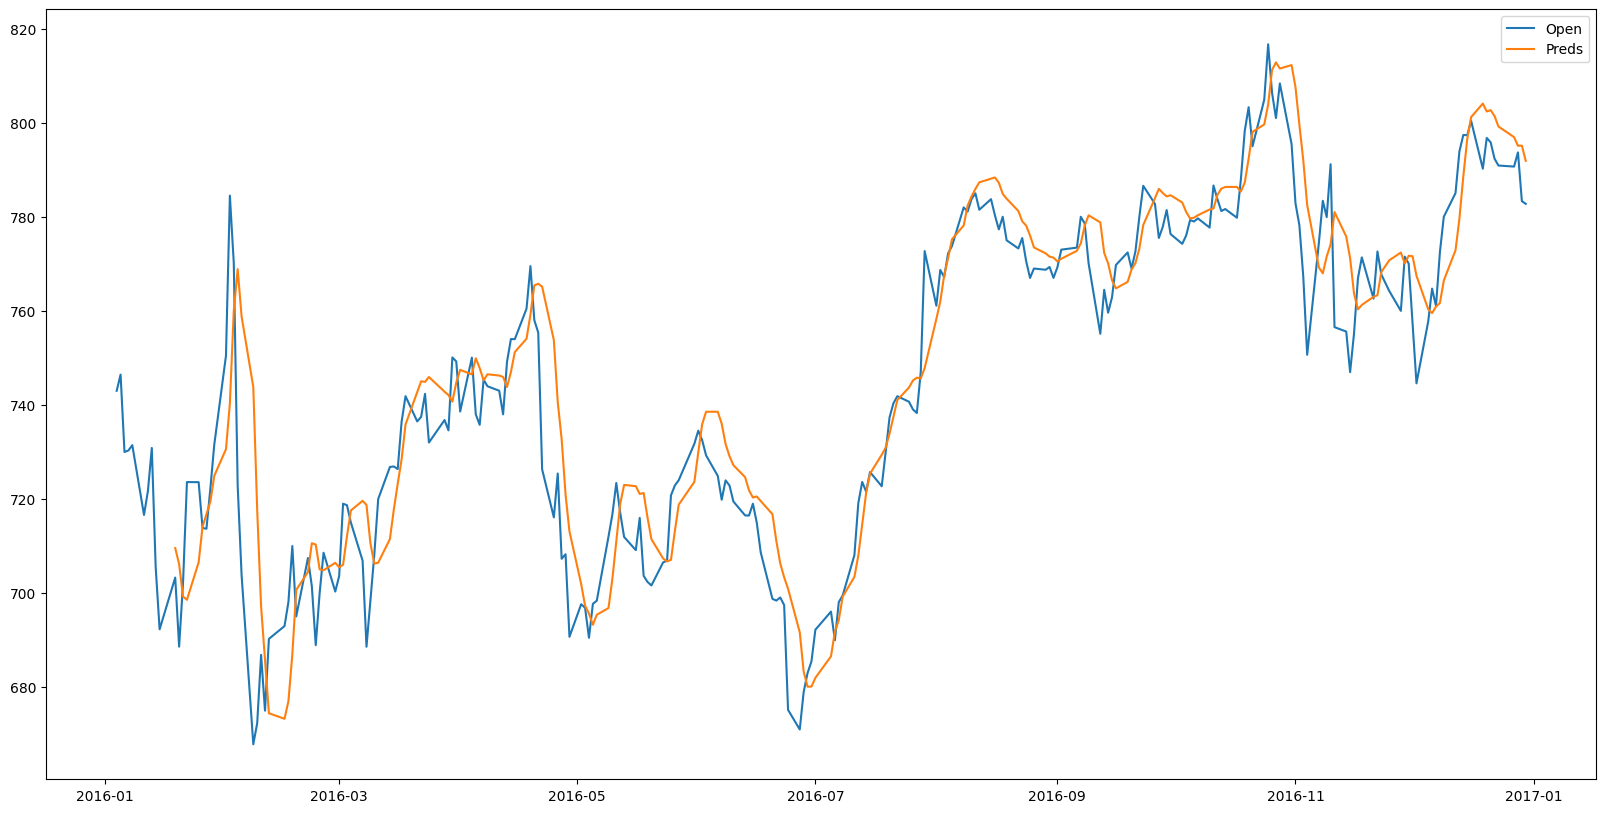

In [878]:
## testing the predictions
with torch.no_grad():
    X_val=X_val.to("cuda",non_blocking=True)
    model=model.cuda()
    y_val_preds=[(pred.item()) for pred in model(X_val)[:,-1,:].squeeze()]
    y_val_preds_df=valid_data.copy()
    y_val_preds_df["Open"]=pd.Series(y_val_preds)
    y_val_preds=pd.DataFrame(scaler.inverse_transform(y_val_preds_df),columns=y_val_preds_df.columns)
    print("valid rmse:",root_mean_squared_error(y_val_preds["Open"].dropna(),train["Open"][time_steps-len(y_val_preds):]))
    plt.figure(figsize=(20,10))
    plt.plot(train["Date"][-len(y_val_preds):],train["Open"][-len(y_val_preds):],label="Open")
    plt.plot(train["Date"][time_steps-len(y_val_preds):],y_val_preds["Open"].dropna(),label="Preds")
    plt.legend()
    plt.show()

### Multivariate RNN

In [894]:
def get_data(data,past_time_steps=20):
    if(past_time_steps>=1):
        X,y=[],[]
        for i in range(len(data)-past_time_steps):
            X.append(data[i:i+past_time_steps].to_numpy().astype('float32'))
            y.append(data[i+1:i+1+past_time_steps].to_numpy().astype('float32'))
        return torch.tensor(X),torch.tensor(y)
    else:
        print("Not a valid past time steps, should be greater than 0")
        return 

In [895]:
class RNN_multi(nn.Module):

    def __init__(self,input_features,hidden_size,output_size,layers=1):
        super().__init__()
        self._input_features=input_features
        self._hidden_size=hidden_size
        self._output_size=output_size
        self._layers=layers
        self.lstm=nn.RNN(input_size=self._input_features,hidden_size=self._hidden_size,num_layers=self._layers,batch_first=True)
        self.linear=nn.Linear(self._hidden_size,self._output_size)
    
    def forward(self,x):

        x,_=self.lstm(x)
        
        x=self.linear(x)
        
        return x

In [896]:
time_steps=10


X_train,y_train=get_data(train_data,time_steps)
print("Shapes of train datasets",X_train.shape,y_train.shape)

X_val,y_val=get_data(valid_data,time_steps)
print("Shapes of valid datasets",X_val.shape,y_val.shape)

train_dataloader=DataLoader(TensorDataset(X_train,y_train),batch_size=8)

rnn_multi=RNN_multi(input_features=5,hidden_size=50,output_size=5)
optimizer=Adam(rnn_multi.parameters(),lr=0.0001)
loss=nn.MSELoss()

train_model(rnn_multi,optimizer,loss,500,train_dataloader,X_val,y_val)

Shapes of train datasets torch.Size([996, 10, 5]) torch.Size([996, 10, 5])
Shapes of valid datasets torch.Size([242, 10, 5]) torch.Size([242, 10, 5])
10 0.1279962017321861 0.12528352322731928
20 0.06742274787156573 0.06647031512679756
30 0.04287427301718485 0.043311549296600055
40 0.03062915812394767 0.0315363069414379
50 0.023738320105566226 0.02475534321925931
60 0.021192906256294705 0.022187920290616402
70 0.020555315603606236 0.021462532340740772
80 0.020342054782062073 0.02117695645377045
90 0.020220870752762677 0.021012474478892488
100 0.020138376151103733 0.020911058398425098
110 0.02007035094145564 0.02084054967825096
120 0.020005308309196158 0.020782313157211258
130 0.019941078104173747 0.020730475924210127
140 0.019877996900225105 0.02068342998910794
150 0.0198163378311753 0.020640134380396667
160 0.019756078856762727 0.02059961177537108
170 0.01969708285391139 0.020560921010432505
180 0.019639298222985175 0.020523320873685677
190 0.019582776557929633 0.02048623633134563
200 

valid rmse Open: 7.582691108763727
valid rmse High: 8.908708680481771
valid rmse Low: 9.504841377480053
valid rmse Close: 9.409233921388536
valid rmse Volume: 689439.496940982


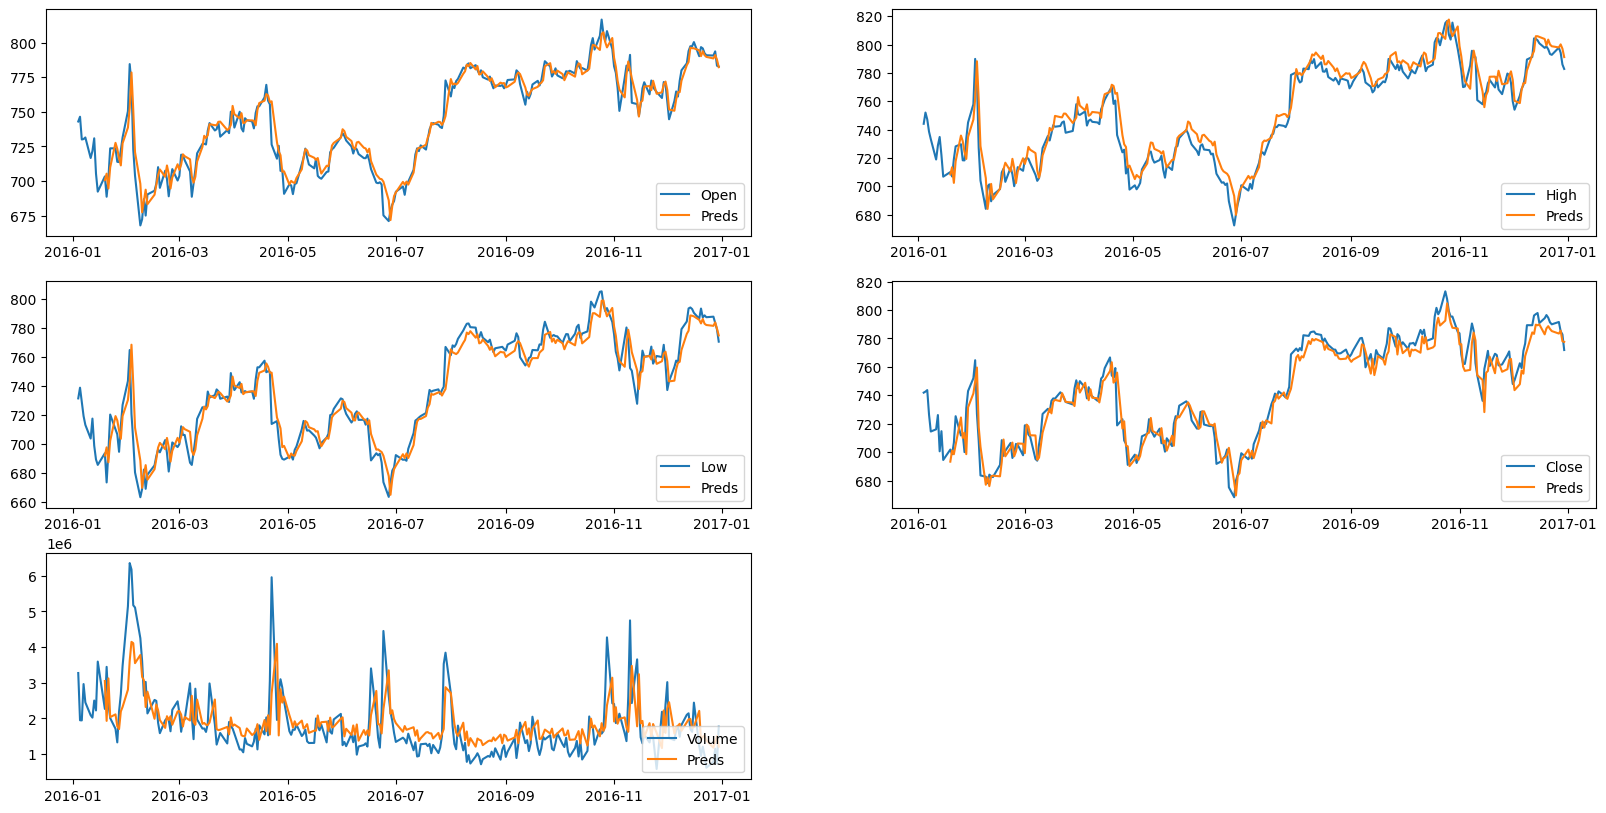

In [897]:
## testing the predictions
with torch.no_grad():
    X_val=X_val.to("cuda",non_blocking=True)
    rnn_multi=rnn_multi.cuda()
    y_val_preds_df=pd.DataFrame(scaler.inverse_transform((rnn_multi(X_val)[:,-1,:].to("cpu").detach().numpy())),columns=valid_data.columns)
    fig,ax=plt.subplots(3,2,figsize=(20,10))
    for i,column in enumerate(y_val_preds_df.columns):
        print(f"valid rmse {column}:", root_mean_squared_error(y_val_preds_df[column],train[column][time_steps-len(valid_data):]))
        # plt.figure(figsize=(20,10))
        ax[int(i//2),i%2].plot(train["Date"][-len(valid_data):],train[column][-len(valid_data):],label=column)
        ax[int(i//2),i%2].plot(train["Date"][time_steps-len(valid_data):],y_val_preds_df[column],label="Preds")
        ax[int(i//2),i%2].legend(loc="lower right")
    
    for i in range(6-len(y_val_preds_df.columns)):
        plt.delaxes(ax.flatten()[-1])
    
    plt.show()

### Multivariate LSTM

In [880]:
class LSTM_multi(nn.Module):

    def __init__(self,input_features,hidden_size,output_size,layers=1):
        super().__init__()
        self._input_features=input_features
        self._hidden_size=hidden_size
        self._output_size=output_size
        self._layers=layers
        self.lstm=nn.LSTM(input_size=self._input_features,hidden_size=self._hidden_size,num_layers=self._layers,batch_first=True)
        self.linear=nn.Linear(self._hidden_size,self._output_size)
    
    def forward(self,x):

        x,_=self.lstm(x)
        
        x=self.linear(x)
        
        return x


In [881]:
time_steps=10


X_train,y_train=get_data(train_data,time_steps)
print("Shapes of train datasets",X_train.shape,y_train.shape)

X_val,y_val=get_data(valid_data,time_steps)
print("Shapes of valid datasets",X_val.shape,y_val.shape)

train_dataloader=DataLoader(TensorDataset(X_train,y_train),batch_size=8)

model_multi=LSTM_multi(input_features=5,hidden_size=50,output_size=5)
optimizer=Adam(model_multi.parameters(),lr=0.0001)
loss=nn.MSELoss()

train_model(model_multi,optimizer,loss,500,train_dataloader,X_val,y_val)


Shapes of train datasets torch.Size([996, 10, 5]) torch.Size([996, 10, 5])
Shapes of valid datasets torch.Size([242, 10, 5]) torch.Size([242, 10, 5])
10 0.22647280397362146 0.2221342710992418
20 0.137755144255135 0.13689008603503156
30 0.08825793865775977 0.08814354638822228
40 0.05705456706124059 0.05694910430321058
50 0.03795485374189236 0.0379362174290422
60 0.028415650997487687 0.028679622672349865
70 0.024361281561671288 0.02496101676006001
80 0.022793956073683102 0.023649109785469035
90 0.022267548264710228 0.023247838034689702
100 0.022050139451211054 0.023062016627029367
110 0.021854153933192195 0.022852990114008796
120 0.02160982264507957 0.02258080909954109
130 0.021336970975074428 0.022277723599522747
140 0.02107949796431597 0.021989567527117976
150 0.020864069528486753 0.021741617329998176
160 0.020692586128258233 0.021536105770174886
170 0.020554851898150685 0.02136507969952055
180 0.02043944269973773 0.021219385125255848
190 0.020338172146693166 0.021091644360827812
200 0

valid rmse Open: 7.492329860069557
valid rmse High: 8.868081865209497
valid rmse Low: 9.083233509542845
valid rmse Close: 8.947774530980796
valid rmse Volume: 722612.4383773741


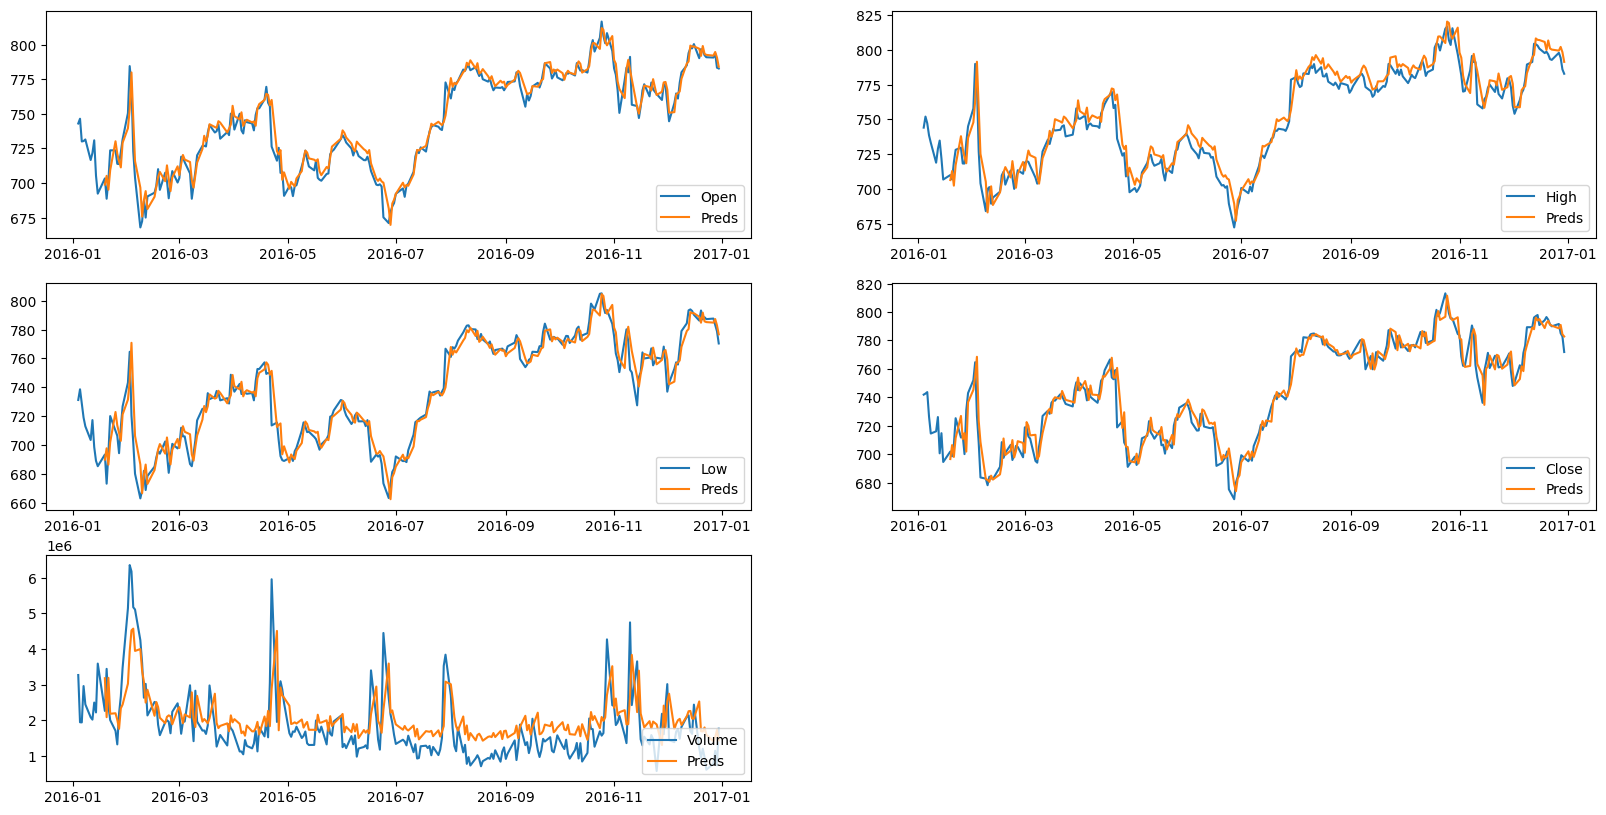

In [882]:
## testing the predictions
with torch.no_grad():
    X_val=X_val.to("cuda",non_blocking=True)
    model_multi=model_multi.cuda()
    y_val_preds_df=pd.DataFrame(scaler.inverse_transform((model_multi(X_val)[:,-1,:].to("cpu").detach().numpy())),columns=valid_data.columns)
    fig,ax=plt.subplots(3,2,figsize=(20,10))
    for i,column in enumerate(y_val_preds_df.columns):
        print(f"valid rmse {column}:", root_mean_squared_error(y_val_preds_df[column],train[column][time_steps-len(valid_data):]))
        # plt.figure(figsize=(20,10))
        ax[int(i//2),i%2].plot(train["Date"][-len(valid_data):],train[column][-len(valid_data):],label=column)
        ax[int(i//2),i%2].plot(train["Date"][time_steps-len(valid_data):],y_val_preds_df[column],label="Preds")
        ax[int(i//2),i%2].legend(loc="lower right")
    
    for i in range(6-len(y_val_preds_df.columns)):
        plt.delaxes(ax.flatten()[-1])
    
    plt.show()

## Final Model

Shapes of valid datasets torch.Size([10, 10, 5]) torch.Size([10, 10, 5])
test rmse Open: 7.21158061731834
test rmse High: 9.865881218513454
test rmse Low: 9.283719965393677
test rmse Close: 9.597471445107447
test rmse Volume: 622453.1319862426


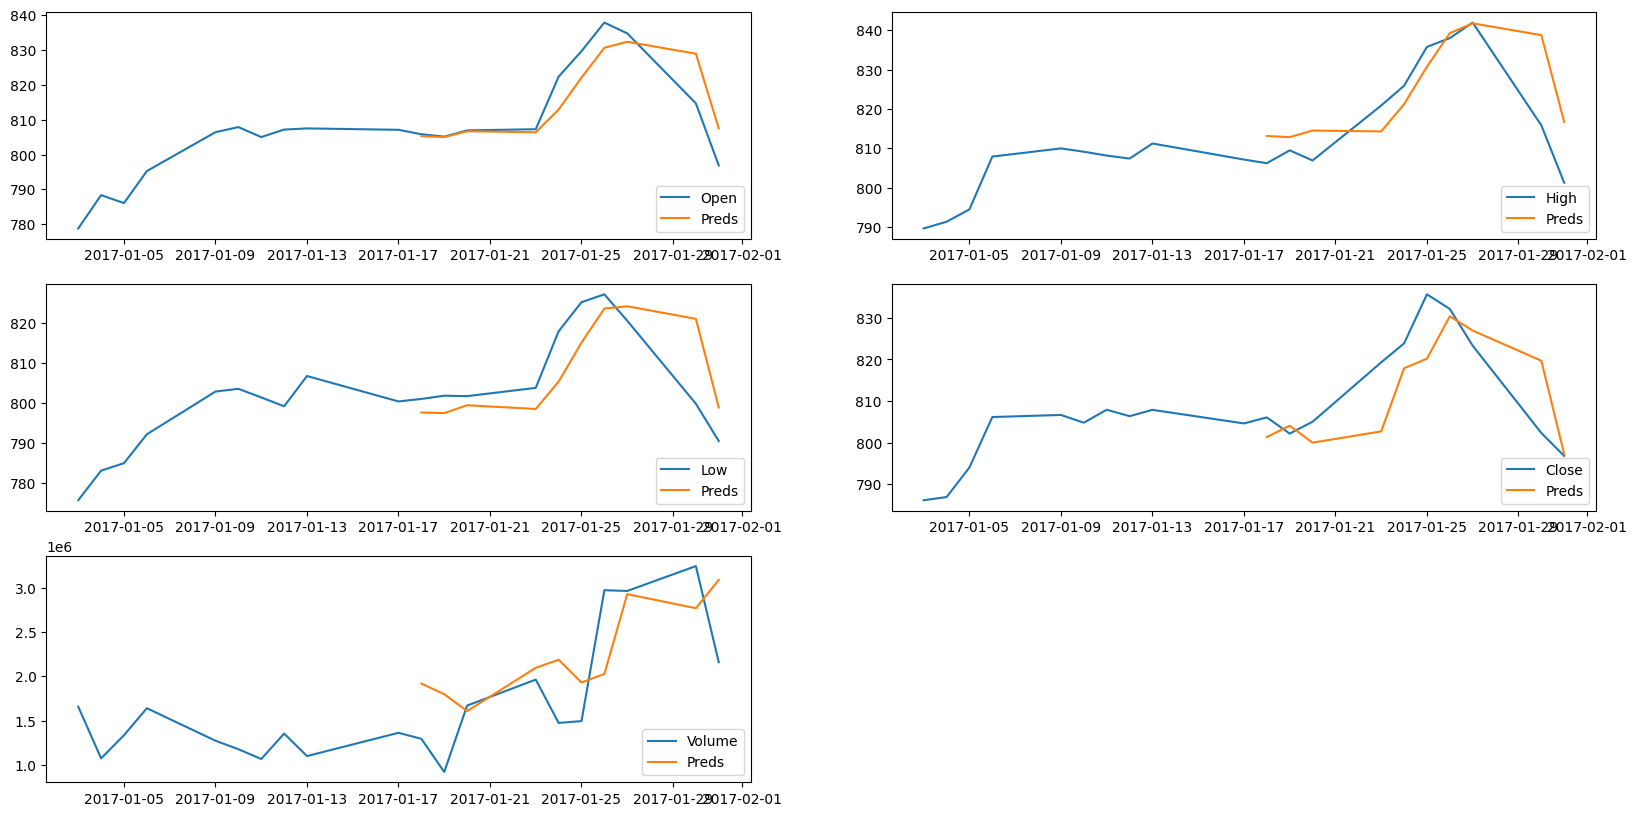

In [ ]:
## selecting based on the perforamnce of univariate and avg performance of the multivariate (4 main columns open,high,close and low)
# we select multivariate LSTM as the final model 
## testing the predictions
X_test,y_test=get_data(test_data,time_steps)
print("Shapes of valid datasets",X_test.shape,y_test.shape)
with torch.no_grad():
    X_test=X_test.to("cuda",non_blocking=True)
    model_multi=model_multi.cuda()
    y_test_preds_df=pd.DataFrame(scaler.inverse_transform((model_multi(X_test)[:,-1,:].to("cpu").detach().numpy())),columns=test_data.columns)
    fig,ax=plt.subplots(3,2,figsize=(20,10))
    for i,column in enumerate(y_test_preds_df.columns):
        print(f"test rmse {column}:", root_mean_squared_error(y_test_preds_df[column],test[column][time_steps-len(test_data):]))
        # plt.figure(figsize=(20,10))
        ax[int(i//2),i%2].plot(test["Date"][-len(test_data):],test[column][-len(test_data):],label=column)
        ax[int(i//2),i%2].plot(test["Date"][time_steps-len(test_data):],y_test_preds_df[column],label="Preds")
        ax[int(i//2),i%2].legend(loc="lower right")
    
    for i in range(6-len(y_test_preds_df.columns)):
        plt.delaxes(ax.flatten()[-1])
    
    plt.show()